In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
 
# prepare dataset
 
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) # 归一化,均值和方差
 
train_dataset = datasets.MNIST(root='./mnist/', train=True, download=False, transform=transform)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = datasets.MNIST(root='./mnist/', train=False, download=False, transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
 
# design model using class
class InceptionA(nn.Module):
    def __init__(self, in_channels):
        super(InceptionA, self).__init__()
        self.branch1x1 = nn.Conv2d(in_channels, 16, kernel_size=1)
 
        self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)
 
        self.branch3x3_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3x3_3 = nn.Conv2d(24, 24, kernel_size=3, padding=1)
 
        self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)
 
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
 
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
 
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)
 
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
 
        outputs = [branch1x1, branch5x5, branch3x3, branch_pool]
        return torch.cat(outputs, dim=1) # b,c,w,h  c对应的是dim=1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(88, 20, kernel_size=5) # 88 = 24x3 + 16
 
        self.incep1 = InceptionA(in_channels=10) # 与conv1 中的10对应
        self.incep2 = InceptionA(in_channels=20) # 与conv2 中的20对应
 
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(1408, 10) 
 
 
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = self.incep1(x)
        x = F.relu(self.mp(self.conv2(x)))
        x = self.incep2(x)
        x = x.view(in_size, -1)
        x = self.fc(x)
 
        return x
 
model = Net()
 
# construct loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
 
# training cycle forward, backward, update
 
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        optimizer.zero_grad()
 
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
 
        running_loss += loss.item()
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch+1, batch_idx+1, running_loss/300))
            running_loss = 0.0
 
 
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('accuracy on test set: %d %% ' % (100*correct/total))
 
 
if __name__ == '__main__':
    for epoch in range(10):
        train(epoch)
        test()

[1,   300] loss: 0.799
[1,   600] loss: 0.187
[1,   900] loss: 0.141
accuracy on test set: 97 % 
[2,   300] loss: 0.117
[2,   600] loss: 0.097
[2,   900] loss: 0.095
accuracy on test set: 97 % 
[3,   300] loss: 0.079
[3,   600] loss: 0.081
[3,   900] loss: 0.075
accuracy on test set: 97 % 
[4,   300] loss: 0.068
[4,   600] loss: 0.065
[4,   900] loss: 0.063
accuracy on test set: 98 % 
[5,   300] loss: 0.057
[5,   600] loss: 0.057
[5,   900] loss: 0.055
accuracy on test set: 98 % 
[6,   300] loss: 0.048
[6,   600] loss: 0.051
[6,   900] loss: 0.052
accuracy on test set: 98 % 
[7,   300] loss: 0.043
[7,   600] loss: 0.049
[7,   900] loss: 0.045
accuracy on test set: 98 % 
[8,   300] loss: 0.041
[8,   600] loss: 0.041
[8,   900] loss: 0.042
accuracy on test set: 98 % 
[9,   300] loss: 0.036
[9,   600] loss: 0.042
[9,   900] loss: 0.038
accuracy on test set: 98 % 
[10,   300] loss: 0.033
[10,   600] loss: 0.036
[10,   900] loss: 0.037
accuracy on test set: 98 % 


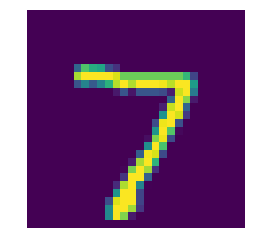

7


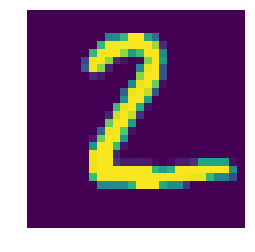

2


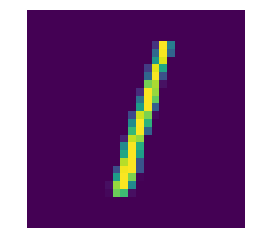

1


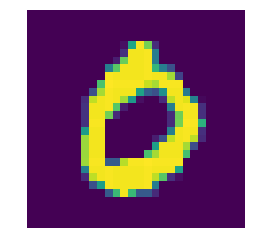

0


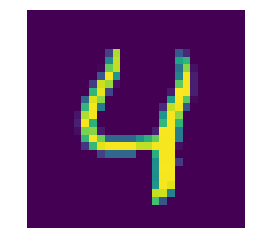

4


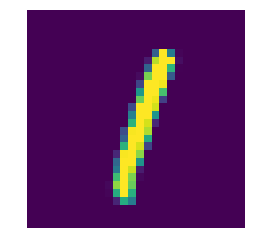

1


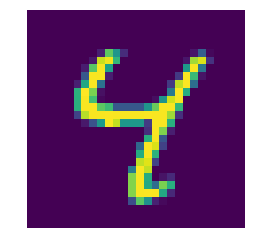

4


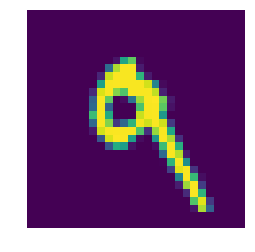

9


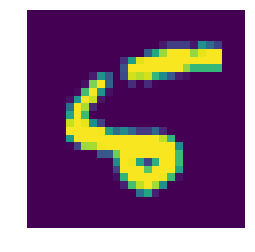

5


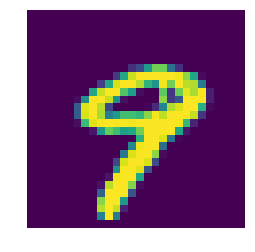

9


In [3]:
 import matplotlib.pyplot as plt
    
    
# def test():
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for data in test_loader:
#             images, labels = data
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, dim=1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     print('accuracy on test set: %d %% ' % (100*correct/total))、
    
    
    
correct = 0
total = 0
n = 10
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)
        
    
        img = images[:n]
        pre = predicted[:n]
        
        break


for i in range(n):
    plt.imshow(img[i][0])
    plt.axis('off') # 不显示坐标轴
    plt.show()
    print(pre[i].numpy())